# Creacion del csv y uso de Box-Cox

En este jupiter me centrare en aplicar la transformacion box-cox a las variables numericas y tambien detectar multicolinealidad y corregirla en caso de existir todo esto previo a crear el csv que usaremos para la creacion del modelo mas adelante

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant # Para VIF
import json # Para guardar los lambdas en JSON
import os   # Para asegurar que el directorio exista

# Cargamos el dataset original
df_laptops = pd.read_csv("dataset/p_laptops.csv", encoding='latin-1')

In [2]:
# Definimos las listas de características
numeric_features_original = [
    'Inches',
    'Ram',
    'Weight',
    'ScreenW',
    'ScreenH',
    'CPU_freq',
    'PrimaryStorage',
    'SecondaryStorage'
]

binary_features = [
    'Touchscreen',
    'IPSpanel',
    'RetinaDisplay'
]

categorical_features = [
    'Company',
    'TypeName',
    'OS',
    'PrimaryStorageType',
    'SecondaryStorageType',
    'CPU_company',
    'GPU_company'
]

target_variable = 'Price_euros'

# Diccionario para almacenar los lambdas de Box-Cox
boxcox_lambdas = {}

# Aplicamos Transformación Box-Cox a Variables Numéricas Predictoras y Objetivo

print("\n--- Aplicando Transformación Box-Cox a Variables Numéricas Predictoras y Objetivo ---")

# Transformamos variables numéricas predictoras 
for feature in numeric_features_original:
    if feature not in df_laptops.columns:
        print(f"Advertencia: La columna '{feature}' no se encontró. Saltando transformación.")
        continue

    data_to_transform = df_laptops[feature].dropna()

    # Manejamos de ceros/negativos para Box-Cox
    if (data_to_transform <= 0).any():
        print(f"  '{feature}' contiene valores no positivos o cero. Sumando 1 para Box-Cox.")
        temp_col = df_laptops[feature].fillna(0) + 1
    else:
        temp_col = df_laptops[feature]

    # Evitamos transformar si todos los valores son iguales (varianza 0)
    if temp_col.nunique() == 1:
        print(f"  Advertencia: '{feature}' tiene un solo valor único. No se aplica Box-Cox.")
        df_laptops[f'{feature}_BoxCox'] = df_laptops[feature] # Mantener original
        boxcox_lambdas[feature] = None # Indicar que no se aplicó Box-Cox
        continue

    # Aplicar Box-Cox y guardar lambda
    transformed_data, lambda_val = boxcox(temp_col.dropna())
    df_laptops[f'{feature}_BoxCox'] = temp_col.apply(lambda x: boxcox([x], lmbda=lambda_val)[0] if pd.notna(x) else np.nan)

    boxcox_lambdas[feature] = lambda_val
    print(f"  '{feature}' transformado a '{feature}_BoxCox' con lambda = {lambda_val:.3f}")

#  Transformamos la variable objetivo (Price_euros) 
if target_variable not in df_laptops.columns:
    print(f"Error: La columna '{target_variable}' no se encontró. No se puede transformar.")
else:
    price_data = df_laptops[target_variable].dropna()
    if (price_data <= 0).any():
        print(f"  '{target_variable}' contiene valores no positivos o cero. Sumando 1 para Box-Cox.")
        temp_price_col = df_laptops[target_variable].fillna(0) + 1
    else:
        temp_price_col = df_laptops[target_variable]

    if temp_price_col.nunique() == 1:
        print(f"  Advertencia: '{target_variable}' tiene un solo valor único. No se aplica Box-Cox.")
        df_laptops[f'{target_variable}_BoxCox'] = df_laptops[target_variable]
        boxcox_lambdas[target_variable] = None
    else:
        transformed_price, lambda_price = boxcox(temp_price_col.dropna())
        df_laptops[f'{target_variable}_BoxCox'] = temp_price_col.apply(lambda x: boxcox([x], lmbda=lambda_price)[0] if pd.notna(x) else np.nan)
        boxcox_lambdas[target_variable] = lambda_price
        print(f"  '{target_variable}' transformado a '{target_variable}_BoxCox' con lambda = {lambda_price:.3f}")

#  Aseguramos que las binarias son 0/1 (si no lo estaban ya) 
print("\nConvirtiendo variables binarias a 0/1 (si es necesario)")
for col_bin in binary_features:
    if col_bin in df_laptops.columns and df_laptops[col_bin].dtype == 'object':
        df_laptops[col_bin] = df_laptops[col_bin].apply(lambda x: 1 if x == 'Yes' else 0)
        print(f"  Columna '{col_bin}' convertida a binario (0/1).")



--- Aplicando Transformación Box-Cox a Variables Numéricas Predictoras y Objetivo ---
  'Inches' transformado a 'Inches_BoxCox' con lambda = 2.657
  'Ram' transformado a 'Ram_BoxCox' con lambda = -0.186
  'Weight' transformado a 'Weight_BoxCox' con lambda = 0.013
  'ScreenW' transformado a 'ScreenW_BoxCox' con lambda = -1.043
  'ScreenH' transformado a 'ScreenH_BoxCox' con lambda = -1.065
  'CPU_freq' transformado a 'CPU_freq_BoxCox' con lambda = 2.481
  'PrimaryStorage' transformado a 'PrimaryStorage_BoxCox' con lambda = 0.201
  'SecondaryStorage' contiene valores no positivos o cero. Sumando 1 para Box-Cox.
  'SecondaryStorage' transformado a 'SecondaryStorage_BoxCox' con lambda = -0.869
  'Price_euros' transformado a 'Price_euros_BoxCox' con lambda = 0.118

Convirtiendo variables binarias a 0/1 (si es necesario)



--- 3. Análisis de Multicolinealidad ---


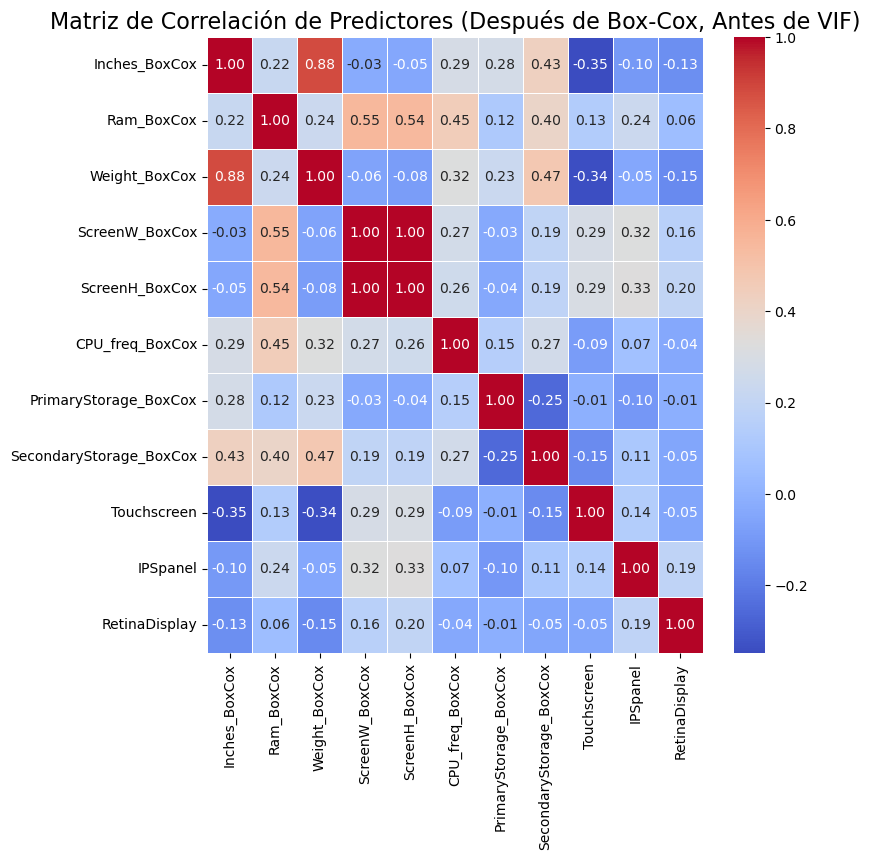

In [3]:
print("\n--- 3. Análisis de Multicolinealidad ---")

# Lista de características numéricas y binarias *transformadas* para el análisis de multicolinealidad
# Incluiremos ScreenW_BoxCox y ScreenH_BoxCox inicialmente para ver su alta correlación
features_for_multicollinearity = [f'{col}_BoxCox' for col in numeric_features_original if f'{col}_BoxCox' in df_laptops.columns] + binary_features

# Limpiamos NaN para el cálculo de la matriz de correlación y VIF
# Es importante que el DataFrame usado para VIF no contenga NaN
df_for_corr_vif = df_laptops[features_for_multicollinearity].dropna()

# Matriz de Correlación ANTES de corregir multicolinealidad 
plt.figure(figsize=(8, 8))
corr_matrix_pre = df_for_corr_vif.corr()
sns.heatmap(corr_matrix_pre, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Predictores (Después de Box-Cox, Antes de VIF)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [4]:
# Calculamos VIF (Factor de Inflación de Varianza) 
# Se recomienda que añadamos una constante para el cálculo de VIF en statsmodels
X_vif = add_constant(df_for_corr_vif) # Añade una columna de 1s para el intercepto

# Calcular VIF para cada predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Eliminar la constante de la tabla VIF para mayor claridad
vif_data = vif_data[vif_data['feature'] != 'const']
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

print("\n--- Factores de Inflación de Varianza (VIF) ---")
print(vif_data)


--- Factores de Inflación de Varianza (VIF) ---
                    feature         VIF
0            ScreenH_BoxCox  211.819410
1            ScreenW_BoxCox  208.142974
2             Weight_BoxCox    5.124144
3             Inches_BoxCox    4.881667
4                Ram_BoxCox    1.990361
5   SecondaryStorage_BoxCox    1.925862
6     PrimaryStorage_BoxCox    1.459240
7             RetinaDisplay    1.383134
8           CPU_freq_BoxCox    1.376437
9               Touchscreen    1.346756
10                 IPSpanel    1.189624


In [5]:
print("\n 4. Corrigiendo Multicolinealidad ")

# La regla general implica que eliminemos variables con VIF > 5 o VIF > 10.
# 'ScreenW_BoxCox' y 'ScreenH_BoxCox' son casi siempre los culpables por diseño.
# Reemplazaremos ScreenW_BoxCox y ScreenH_BoxCox por ScreenPixels_BoxCox.

# Calculamos ScreenPixels en el DataFrame original si no existe
# Es importante que ScreenPixels se cree a partir de las columnas ORIGINALES
if 'ScreenPixels' not in df_laptops.columns:
    df_laptops['ScreenPixels'] = df_laptops['ScreenW'] * df_laptops['ScreenH']
    print("Creando 'ScreenPixels' a partir de 'ScreenW' y 'ScreenH' originales.")

# Aplicar Box-Cox a ScreenPixels
screen_pixels_data = df_laptops['ScreenPixels'].dropna()
if (screen_pixels_data <= 0).any():
    print(f"  'ScreenPixels' contiene valores no positivos o cero. Sumando 1 para Box-Cox.")
    temp_screen_pixels_col = df_laptops['ScreenPixels'].fillna(0) + 1
else:
    temp_screen_pixels_col = df_laptops['ScreenPixels']

if temp_screen_pixels_col.nunique() == 1:
    print(f"  Advertencia: 'ScreenPixels' tiene un solo valor único. No se aplica Box-Cox.")
    df_laptops['ScreenPixels_BoxCox'] = df_laptops['ScreenPixels']
    boxcox_lambdas['ScreenPixels'] = None
else:
    transformed_screen_pixels, lambda_screen_pixels = boxcox(temp_screen_pixels_col.dropna())
    df_laptops['ScreenPixels_BoxCox'] = temp_screen_pixels_col.apply(lambda x: boxcox([x], lmbda=lambda_screen_pixels)[0] if pd.notna(x) else np.nan)
    boxcox_lambdas['ScreenPixels'] = lambda_screen_pixels
    print(f"  'ScreenPixels' transformado a 'ScreenPixels_BoxCox' con lambda = {lambda_screen_pixels:.3f}")

# Lista de características numéricas finales DESPUÉS de la corrección de multicolinealidad
# Excluimos ScreenW_BoxCox y ScreenH_BoxCox, y añadimos ScreenPixels_BoxCox
final_numeric_features_for_model = [
    f'{col}_BoxCox' for col in numeric_features_original
    if col not in ['ScreenW', 'ScreenH'] and f'{col}_BoxCox' in df_laptops.columns
]
final_numeric_features_for_model.append('ScreenPixels_BoxCox') # Añadir la nueva variable combinada

print(f"\nVariables numéricas finales seleccionadas después de Box-Cox y corrección de multicolinealidad: {final_numeric_features_for_model}")


 4. Corrigiendo Multicolinealidad 
Creando 'ScreenPixels' a partir de 'ScreenW' y 'ScreenH' originales.
  'ScreenPixels' transformado a 'ScreenPixels_BoxCox' con lambda = -0.525

Variables numéricas finales seleccionadas después de Box-Cox y corrección de multicolinealidad: ['Inches_BoxCox', 'Ram_BoxCox', 'Weight_BoxCox', 'CPU_freq_BoxCox', 'PrimaryStorage_BoxCox', 'SecondaryStorage_BoxCox', 'ScreenPixels_BoxCox']



 Factores de Inflación de Varianza (VIF) DESPUÉS de la corrección 
                   feature       VIF
0            Weight_BoxCox  5.070458
1            Inches_BoxCox  4.879668
2               Ram_BoxCox  1.990110
3  SecondaryStorage_BoxCox  1.924090
4      ScreenPixels_BoxCox  1.749005
5    PrimaryStorage_BoxCox  1.456823
6          CPU_freq_BoxCox  1.374978
7              Touchscreen  1.338364
8                 IPSpanel  1.189410
9            RetinaDisplay  1.115719


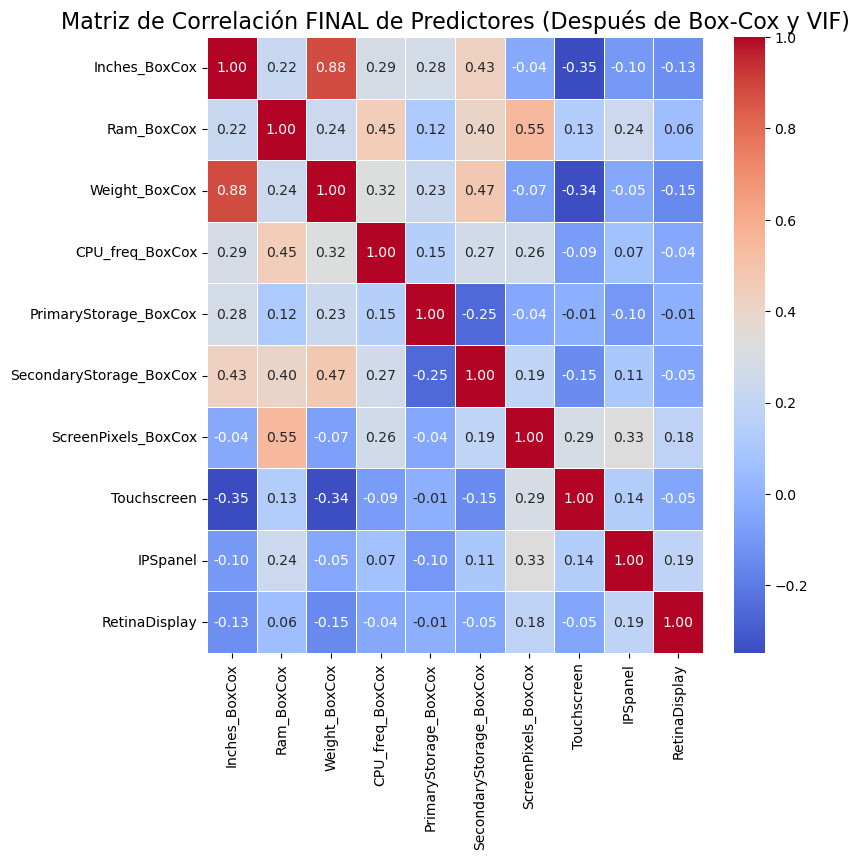

In [6]:
# Re-evaluar VIF después de la corrección 
# Creamos un nuevo DataFrame para VIF con las columnas corregidas
features_after_correction = final_numeric_features_for_model + binary_features
df_for_corr_vif_corrected = df_laptops[features_after_correction].dropna()
X_vif_corrected = add_constant(df_for_corr_vif_corrected)

vif_data_corrected = pd.DataFrame()
vif_data_corrected["feature"] = X_vif_corrected.columns
vif_data_corrected["VIF"] = [variance_inflation_factor(X_vif_corrected.values, i) for i in range(X_vif_corrected.shape[1])]
vif_data_corrected = vif_data_corrected[vif_data_corrected['feature'] != 'const']
vif_data_corrected = vif_data_corrected.sort_values(by="VIF", ascending=False).reset_index(drop=True)

print("\n Factores de Inflación de Varianza (VIF) DESPUÉS de la corrección ")
print(vif_data_corrected)

# Matriz de Correlación FINAL de Predictores 
plt.figure(figsize=(8, 8))
corr_matrix_post = df_for_corr_vif_corrected.corr()
sns.heatmap(corr_matrix_post, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación FINAL de Predictores (Después de Box-Cox y VIF)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


 Matriz de Correlación FINAL de Predictores y Variable Objetivo (Después de Box-Cox y VIF) 


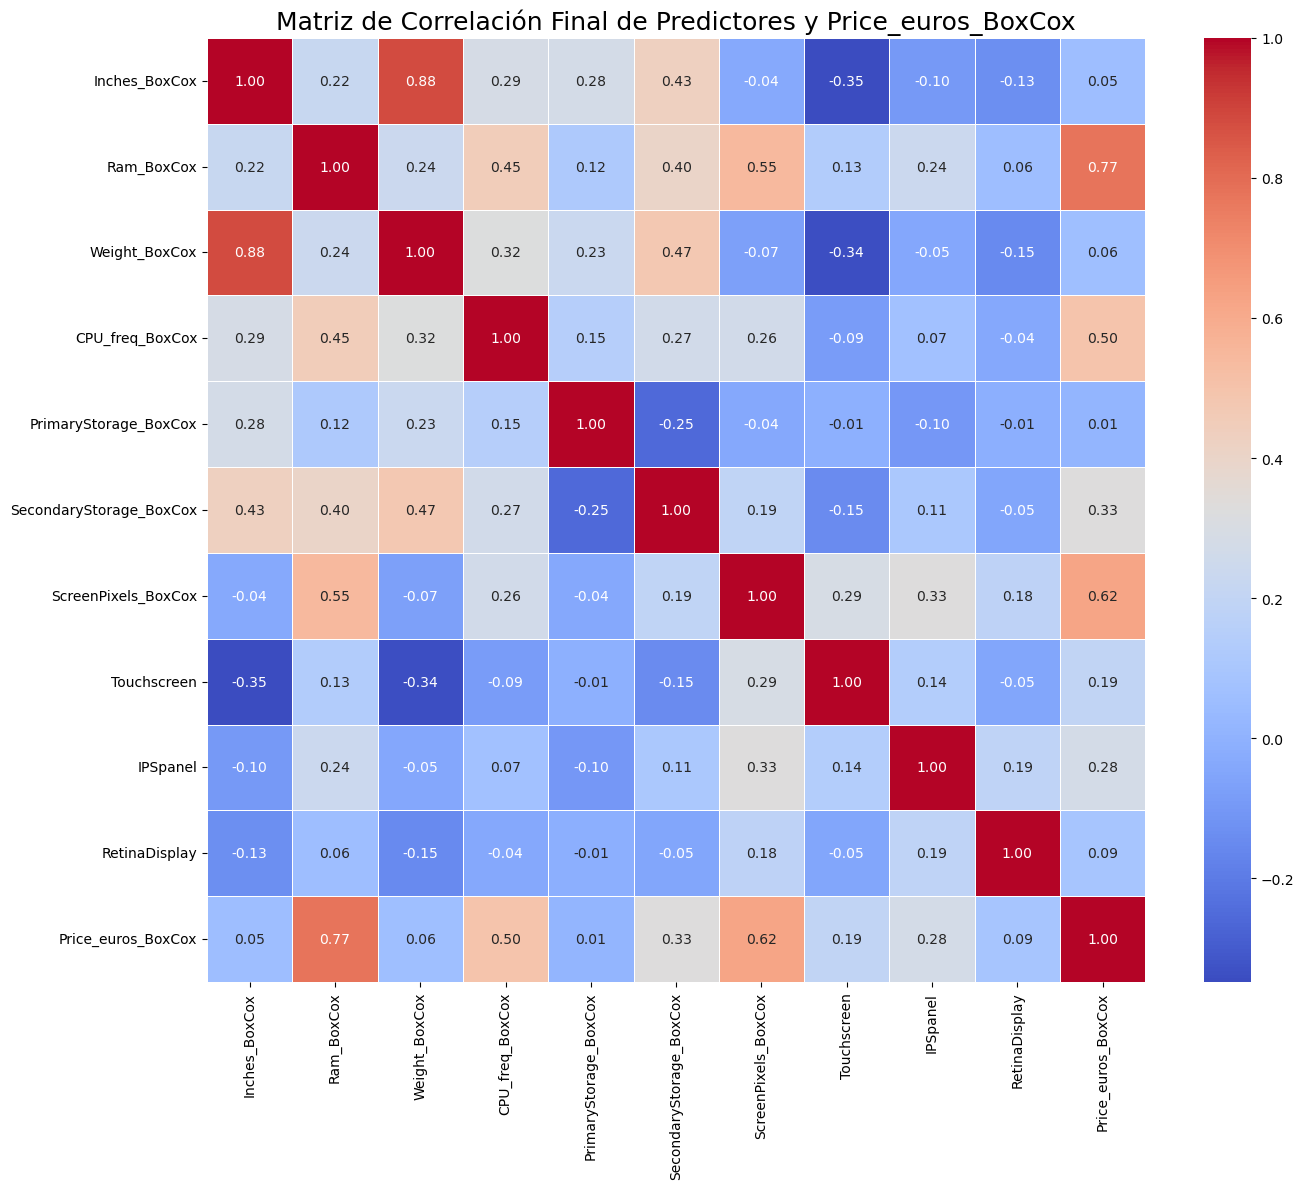

In [7]:
# Definimos las listas de características (asegurando que ScreenPixels_BoxCox esté en la numérica final)
numeric_features_original_for_lists = [
    'Inches', 'Ram', 'Weight', 'CPU_freq', 'PrimaryStorage', 'SecondaryStorage'
] # Estas son las que se habrían transformado individualmente, excluyendo W/H
binary_features = [
    'Touchscreen', 'IPSpanel', 'RetinaDisplay'
]
categorical_features = [ # Se incluyen aquí para consistencia, aunque no estarán en la matriz de correlación numérica
    'Company', 'TypeName', 'OS', 'PrimaryStorageType', 'SecondaryStorageType',
    'CPU_company', 'GPU_company'
]
target_variable = 'Price_euros'

# Lista de características numéricas finales (Box-Cox) y binarias para la matriz de correlación
# Excluimos ScreenW y ScreenH, e incluimos ScreenPixels_BoxCox
all_features_for_final_corr = [f'{col}_BoxCox' for col in numeric_features_original_for_lists if f'{col}_BoxCox' in df_laptops.columns]
all_features_for_final_corr.append('ScreenPixels_BoxCox') # Añadir la nueva variable combinada
all_features_for_final_corr.extend(binary_features) # Añadir las binarias
all_features_for_final_corr.append(f'{target_variable}_BoxCox') # Añadir la variable objetivo transformada

print("\n Matriz de Correlación FINAL de Predictores y Variable Objetivo (Después de Box-Cox y VIF) ")

# Filtramos el DataFrame para las columnas relevantes y eliminar filas con NaN para el cálculo
df_final_corr = df_laptops[all_features_for_final_corr].dropna()

# Calculamos la matriz de correlación
correlation_matrix_final = df_final_corr.corr()

# Visualizamos la matriz de correlación
plt.figure(figsize=(14, 12)) # Ajustar el tamaño para una mejor visualización
sns.heatmap(correlation_matrix_final, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True)
plt.title('Matriz de Correlación Final de Predictores y Price_euros_BoxCox', fontsize=18)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Ahora tras todo lo hecho anteriormente vamos a seleccionar la variables que conformaran parte del archivo csv donde solo estaran las variables predicctoras del modelo

He decidido incorporar todas la variables numericas y binarias al modelo debido a :

| Concepto                    | Descripción                                                                                                                                                                                                                                                                                                                                                              |
| :-------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Interacciones** | Una variable que parece tener poca o ninguna relevancia por sí misma puede volverse **altamente predictiva cuando se combina** con otra. El efecto combinado de dos o más variables es diferente (y a menudo mayor) que la suma de sus efectos individuales. Esto es crucial cuando el impacto de una variable depende del nivel de otra.                                        |
| **Relaciones No Lineales** | La correlación de Pearson solo capta **relaciones lineales**. Sin embargo, muchas relaciones en el mundo real son no lineales (por ejemplo, cuadráticas, exponenciales, logarítmicas). Una característica que no muestra una fuerte correlación lineal podría tener una relación no lineal muy fuerte con la variable objetivo, capturable mediante transformaciones.                  |
| **Supresión de Ruido o Efecto Confounder** | Una variable con baja correlación con la variable objetivo puede ser útil si ayuda a **explicar la varianza en otras variables predictoras** que sí están fuertemente correlacionadas. Al incluirla, se "elimina" el ruido o el efecto de confusión, lo que permite que las relaciones de los predictores clave con la variable objetivo se estimen de forma más precisa y robusta. |

In [8]:
""" 

# Las variables numéricas a incluir (ya transformadas con Box-Cox y corregida multicolinealidad)
final_selected_numeric_features = [
    'Inches_BoxCox',
    'Ram_BoxCox',
    'Weight_BoxCox',
    'CPU_freq_BoxCox',
    'PrimaryStorage_BoxCox',
    'SecondaryStorage_BoxCox',
    'ScreenPixels_BoxCox' # La variable combinada
]

# Las variables binarias
# Asumimos que 'binary_features' ya está definida desde pasos anteriores
# (Si no, necesitarías definirla aquí: binary_features = ['Touchscreen', 'IPSpanel', 'RetinaDisplay'])

# Las variables categóricas
# Asumimos que 'categorical_features' ya está definida desde pasos anteriores
# (Si no, necesitarías definirla aquí: categorical_features = ['Company', 'TypeName', 'OS', ...])

# La variable objetivo transformada
target_variable = 'Price_euros' # Asegurarse de que target_variable está definida
final_target_feature = f'{target_variable}_BoxCox'


# Combinamos todas las listas de columnas para el DataFrame final
columns_for_final_csv = (
    final_selected_numeric_features +
    binary_features +
    categorical_features +
    [final_target_feature]
)

# Creamos el DataFrame final 'df_model_ready' ---
print("\nCreando el DataFrame final 'df_model_ready' ")

# Filtramos solo las columnas que realmente existen en df_laptops
# Esto es una buena práctica que hacemos para evitar KeyError si alguna columna no se generó por alguna razón
columns_for_final_csv_existing = [col for col in columns_for_final_csv if col in df_laptops.columns]

df_model_ready = df_laptops[columns_for_final_csv_existing].copy()

# Guardamos el DataFrame a CSV y los lambdas a JSON 
output_csv_path = "dataset/df_model_ready.csv"
df_model_ready.to_csv(output_csv_path, index=False, encoding='latin-1')
print(f"\nDataFrame 'df_model_ready.csv' guardado exitosamente en: {output_csv_path}")

# Guardamos los lambdas en un archivo JSON
lambdas_file_path = "model_artifacts/boxcox_lambdas.json"
# Aseguramos de que el directorio 'model_artifacts' exista
os.makedirs(os.path.dirname(lambdas_file_path), exist_ok=True)

# Convertimos cualquier valor 'None' en el diccionario a None de Python (para JSON)
serializable_lambdas = {k: (v if v is not None else None) for k, v in boxcox_lambdas.items()}

with open(lambdas_file_path, 'w') as f:
    json.dump(serializable_lambdas, f, indent=4) # indent=4 para un JSON más legible
print(f"Coeficientes lambda de Box-Cox guardados en: {lambdas_file_path}")

"""

' \n\n# Las variables numéricas a incluir (ya transformadas con Box-Cox y corregida multicolinealidad)\nfinal_selected_numeric_features = [\n    \'Inches_BoxCox\',\n    \'Ram_BoxCox\',\n    \'Weight_BoxCox\',\n    \'CPU_freq_BoxCox\',\n    \'PrimaryStorage_BoxCox\',\n    \'SecondaryStorage_BoxCox\',\n    \'ScreenPixels_BoxCox\' # La variable combinada\n]\n\n# Las variables binarias\n# Asumimos que \'binary_features\' ya está definida desde pasos anteriores\n# (Si no, necesitarías definirla aquí: binary_features = [\'Touchscreen\', \'IPSpanel\', \'RetinaDisplay\'])\n\n# Las variables categóricas\n# Asumimos que \'categorical_features\' ya está definida desde pasos anteriores\n# (Si no, necesitarías definirla aquí: categorical_features = [\'Company\', \'TypeName\', \'OS\', ...])\n\n# La variable objetivo transformada\ntarget_variable = \'Price_euros\' # Asegurarse de que target_variable está definida\nfinal_target_feature = f\'{target_variable}_BoxCox\'\n\n\n# Combinamos todas las listas